# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [1]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [3]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [4]:
print df.shape, df.is_blocked.mean()
df[0:3]
#df.get('category')

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [5]:
print "Blocked ratio",df.is_blocked.sum()
print "Count:",len(df)

Blocked ratio 274996
Count: 1204949


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [6]:
#downsample

k,n=(0,0)
fordrop=[]
#< downsample data so that both classes have approximately equal ratios>
for index, row in df.iterrows():
    if row['is_blocked']==0:
        fordrop.append(k)
        n+=1
    k+=1
    if n==654957:
        break
#print fordrop
df = df.drop(df.index[fordrop])


print "Blocked ratio:",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio: 0.5
Count: 549992


In [7]:
fordrop,k,n=(0,0,0)
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


In [ ]:
#In case your RAM-o-meter is in the red
#if very_low_ram:
#    data = data[::2]

# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [33]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

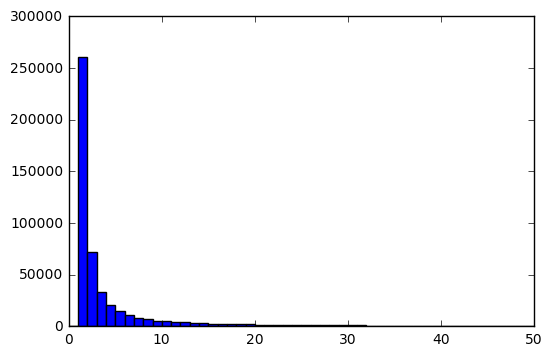

In [34]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [35]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.
min_count = 10
tokens=[]
for i in token_counts.keys():
    if token_counts[i]>=min_count:
        tokens.append(i)
#tokens = <tokens from token_counts keys that had at least min_count occurences throughout the dataset>


In [36]:
len(tokens)

88036

In [37]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [38]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 88037


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [39]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [40]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples


In [41]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (549992, 15)
Поездки на таможню, печать в паспорте -> [17036 14694 55439 82210 80290 17368     0     0     0     0] ...
Рефлекторно-урогинекологический массаж -> [ 8387     0 30504     0     0     0     0     0     0     0] ...
Возьму суду под200 т. р -> [28865 23455     0  3649 33977     0     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [42]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [44]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
for cat_str, subcat_str in df[["category","subcategory"]].values:
    
    cat_dict = {"category":cat_str,"subcategory":subcat_str}
    categories.append(cat_dict)

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [45]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [46]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [48]:
#Split into training and test set.
from sklearn.cross_validation import train_test_split

#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard
data_split=train_test_split(title_tokens,desc_tokens,df_non_text.values,target)
title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_split

## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [1]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_split,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_split = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_split
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print "done"        

Reading saved data...
done


# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [2]:
#libraries
from lasagne.nonlinearities import *
import theano
import theano.tensor as T
import lasagne
import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu")


Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)


In [3]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

In [4]:
print len(target_tr)
print len(desc_tr)

412494
412494


# NN architecture

In [54]:
title_inp = lasagne.layers.InputLayer(shape=(None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer(shape=(None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer(shape=(None,nontext_tr.shape[1]), input_var=categories)

In [57]:
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=128)
descr_nn = lasagne.layers.LSTMLayer(descr_nn,num_units=128,nonlinearity=leaky_rectify)#,only_return_final=True)
descr_nn = lasagne.layers.RecurrentLayer(descr_nn,num_units=128,nonlinearity=leaky_rectify,only_return_final=True)
#RNN or LSTM over embedding, maybe several ones in a stack

# Titles
title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=128)
title_nn = lasagne.layers.RecurrentLayer(title_nn,num_units=128,nonlinearity=leaky_rectify)#,only_return_final=True)
title_nn = lasagne.layers.LSTMLayer(title_nn,num_units=128,nonlinearity=leaky_rectify,only_return_final=True)
# Non-sequences
cat_nn = lasagne.layers.DenseLayer(cat_inp, num_units=156,nonlinearity=leaky_rectify)
#cat_nn = lasagne.layers.LSTMLayer(cat_nn,num_units=64,nonlinearity='rectify')
cat_nn = lasagne.layers.DenseLayer(cat_nn,num_units=312,nonlinearity=leaky_rectify)

In [58]:
nn = lasagne.layers.ConcatLayer([descr_nn,title_nn,cat_nn])                               

nn = lasagne.layers.DenseLayer(nn,512)
nn = lasagne.layers.DropoutLayer(nn,p=0.3)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [59]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [60]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)
#accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_tr).mean()
#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta = 1).mean()

In [61]:
#Weight optimization step
updates = lasagne.updates.adam(loss, weights)

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [62]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta = 1).mean()

### Coffee-lation

In [63]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [64]:
#average precision at K

from oracle import APatK, score

In [65]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [66]:
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
n_epochs = 100
batch_size = 300
minibatches_per_epoch = 300

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in tqdm(enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True))):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

301it [04:33,  1.11it/s]


Train:
	loss: 2932.60216928
	acc: 0.46430786268
	auc: 0.490806412875
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 622.339522626
	acc: 0.496755260244
	auc: 0.498933481479
	ap@k: 0.481981170156


301it [04:31,  1.11it/s]


Train:
	loss: 229.932743337
	acc: 0.492535991141
	auc: 0.509042238104
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 113.125212926
	acc: 0.498194905869
	auc: 0.502946525972
	ap@k: 0.491688592541


301it [04:30,  1.11it/s]


Train:
	loss: 135.748948191
	acc: 0.523266888151
	auc: 0.501768329488
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 45.6062010431
	acc: 0.496290143965
	auc: 0.502906196306
	ap@k: 0.530869179457


301it [04:32,  1.11it/s]


Train:
	loss: 50.6072484153
	acc: 0.53146179402
	auc: 0.502211242215
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 80.6556650069
	acc: 0.491638981174
	auc: 0.480872417063
	ap@k: 0.548426948485


301it [04:31,  1.11it/s]


Train:
	loss: 4126.10099902
	acc: 0.49738648948
	auc: 0.495725834217
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 3.57153504072
	acc: 0.50065337763
	auc: 0.482902062366
	ap@k: 0.486826193487


301it [04:32,  1.07it/s]


Train:
	loss: 2.55992397736
	acc: 0.523743078627
	auc: 0.504673998034
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.69467522114
	acc: 0.502724252492
	auc: 0.513418521705
	ap@k: 0.576056645315


301it [04:34,  1.09it/s]


Train:
	loss: 1.35963029856
	acc: 0.57146179402
	auc: 0.540450156204
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00999591268
	acc: 0.521295681063
	auc: 0.531206472658
	ap@k: 0.531736869675


301it [04:31,  1.11it/s]


Train:
	loss: 1.00290063156
	acc: 0.591107419712
	auc: 0.572534823106
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00015606183
	acc: 0.521638981174
	auc: 0.531792452045
	ap@k: 0.501226205072


301it [04:30,  1.12it/s]


Train:
	loss: 1.0002951678
	acc: 0.592137320044
	auc: 0.571130835284
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00097586136
	acc: 0.512823920266
	auc: 0.52878087455
	ap@k: 0.5011075482


301it [04:32,  1.11it/s]


Train:
	loss: 1.00062479171
	acc: 0.593754152824
	auc: 0.576533125186
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00011697603
	acc: 0.516633444075
	auc: 0.529332738541
	ap@k: 0.492796037619


301it [04:30,  1.11it/s]


Train:
	loss: 0.999793986741
	acc: 0.59300110742
	auc: 0.581768634717
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00024142438
	acc: 0.51146179402
	auc: 0.529936618605
	ap@k: 0.51226392535


301it [04:30,  1.11it/s]


Train:
	loss: 0.999969453781
	acc: 0.588715393134
	auc: 0.584845467901
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00068710899
	acc: 0.511727574751
	auc: 0.527715996397
	ap@k: 0.498330464728


301it [04:30,  1.12it/s]


Train:
	loss: 1.00073751658
	acc: 0.594994462901
	auc: 0.582666589709
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.99994981887
	acc: 0.520520487265
	auc: 0.531768144145
	ap@k: 0.492348901049


301it [04:30,  1.12it/s]


Train:
	loss: 1.00014828053
	acc: 0.591794019934
	auc: 0.581055553555
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.0001555425
	acc: 0.517408637874
	auc: 0.529496027513
	ap@k: 0.492885814994


301it [04:30,  1.11it/s]


Train:
	loss: 1.00030189064
	acc: 0.587740863787
	auc: 0.575679059441
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00043025411
	acc: 0.514008859358
	auc: 0.527195049855
	ap@k: 0.487056032894


301it [04:30,  1.11it/s]


Train:
	loss: 1.0000851594
	acc: 0.598737541528
	auc: 0.593779595987
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00015303327
	acc: 0.515681063123
	auc: 0.527805839795
	ap@k: 0.505190822961


301it [04:30,  1.12it/s]


Train:
	loss: 0.99966316456
	acc: 0.600631229236
	auc: 0.610918053952
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00059245125
	acc: 0.510442967885
	auc: 0.522468313547
	ap@k: 0.510353371157


301it [04:30,  1.12it/s]


Train:
	loss: 0.998835691984
	acc: 0.589911406423
	auc: 0.625898194948
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00068410636
	acc: 0.512812846069
	auc: 0.527680559608
	ap@k: 0.514123925506


301it [04:30,  1.11it/s]


Train:
	loss: 1.00021864062
	acc: 0.589512735327
	auc: 0.616387973176
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00040256578
	acc: 0.519080841639
	auc: 0.533288006594
	ap@k: 0.514588217565


301it [04:30,  1.11it/s]


Train:
	loss: 1.00000111646
	acc: 0.592724252492
	auc: 0.615676925535
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00002485853
	acc: 0.520586932447
	auc: 0.527144609641
	ap@k: 0.523112050017


301it [04:30,  1.12it/s]


Train:
	loss: 0.999234177979
	acc: 0.595271317829
	auc: 0.615493653919
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00068925749
	acc: 0.509988925803
	auc: 0.528738253319
	ap@k: 0.525406016998


301it [04:30,  1.11it/s]


Train:
	loss: 0.998865069024
	acc: 0.590564784053
	auc: 0.619155442301
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00048732522
	acc: 0.511716500554
	auc: 0.528603272002
	ap@k: 0.495038888223


301it [04:30,  1.12it/s]


Train:
	loss: 1.00030162626
	acc: 0.588205980066
	auc: 0.610970881388
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00061950223
	acc: 0.512646733112
	auc: 0.528129900603
	ap@k: 0.520090313284


301it [04:30,  1.11it/s]


Train:
	loss: 0.998312185201
	acc: 0.588316722038
	auc: 0.614056063928
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00091913017
	acc: 0.512403100775
	auc: 0.529323370957
	ap@k: 0.500994281601


301it [04:30,  1.11it/s]


Train:
	loss: 0.997981615512
	acc: 0.587464008859
	auc: 0.61524304764
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00044922783
	acc: 0.514817275748
	auc: 0.530171573893
	ap@k: 0.518383512513


301it [04:30,  1.12it/s]


Train:
	loss: 0.997932300601
	acc: 0.592369878184
	auc: 0.618289019136
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00142664186
	acc: 0.50903654485
	auc: 0.529087286192
	ap@k: 0.511242239668


301it [04:30,  1.12it/s]


Train:
	loss: 0.998780785949
	acc: 0.587220376523
	auc: 0.613259907459
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00061209136
	acc: 0.509534883721
	auc: 0.530604276664
	ap@k: 0.503146065346


301it [04:30,  1.11it/s]


Train:
	loss: 0.998440513952
	acc: 0.589667774086
	auc: 0.615467235062
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00057407306
	acc: 0.516279069767
	auc: 0.532944479354
	ap@k: 0.509550124933


301it [04:30,  1.11it/s]


Train:
	loss: 1.00027353491
	acc: 0.60138427464
	auc: 0.611613412186
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00003421765
	acc: 0.524928017719
	auc: 0.532484273537
	ap@k: 0.522384816556


301it [04:30,  1.12it/s]


Train:
	loss: 1.00048415868
	acc: 0.59438538206
	auc: 0.60400365819
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999559683652
	acc: 0.50934662237
	auc: 0.531954181341
	ap@k: 0.530151930759


301it [04:30,  1.11it/s]


Train:
	loss: 0.999813109291
	acc: 0.505481727575
	auc: 0.534267435542
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999831886112
	acc: 0.500564784053
	auc: 0.510949945601
	ap@k: 0.524686848786


301it [04:30,  1.11it/s]


Train:
	loss: 1.00001175348
	acc: 0.50007751938
	auc: 0.499646787064
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999598839586
	acc: 0.50130675526
	auc: 0.500269089376
	ap@k: 0.521816026014


301it [04:30,  1.11it/s]


Train:
	loss: 1.00009265545
	acc: 0.499789590255
	auc: 0.497485639077
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999342595615
	acc: 0.502236987818
	auc: 0.500774628491
	ap@k: 0.5109998156


301it [04:30,  1.11it/s]


Train:
	loss: 1.00035708173
	acc: 0.498837209302
	auc: 0.501423648596
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999615294614
	acc: 0.501362126246
	auc: 0.50481942015
	ap@k: 0.52990158548


301it [04:30,  1.11it/s]


Train:
	loss: 0.999536108853
	acc: 0.504163898117
	auc: 0.505531496363
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999972630558
	acc: 0.500088593577
	auc: 0.503970671285
	ap@k: 0.541669476074


301it [04:30,  1.11it/s]


Train:
	loss: 1.00058900901
	acc: 0.498161683278
	auc: 0.500257182634
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.998982778709
	acc: 0.503543743079
	auc: 0.500302317466
	ap@k: 0.518100666022


301it [04:30,  1.11it/s]


Train:
	loss: 0.999093680412
	acc: 0.502990033223
	auc: 0.500172833069
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.99948437889
	acc: 0.501483942414
	auc: 0.500012414983
	ap@k: 0.528780049636


301it [04:30,  1.12it/s]


Train:
	loss: 1.00056446759
	acc: 0.498416389812
	auc: 0.493192330372
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999349570732
	acc: 0.502081949059
	auc: 0.500022702375
	ap@k: 0.517282729154


301it [04:30,  1.11it/s]


Train:
	loss: 0.999909362909
	acc: 0.500387596899
	auc: 0.495755464215
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999648331109
	acc: 0.501074197121
	auc: 0.500033983839
	ap@k: 0.481055458185


301it [04:30,  1.11it/s]


Train:
	loss: 1.00001479007
	acc: 0.500044296788
	auc: 0.496635732471
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999458754577
	acc: 0.501661129568
	auc: 0.500033405445
	ap@k: 0.501795038482


301it [04:30,  1.11it/s]


Train:
	loss: 0.999624077409
	acc: 0.501184939092
	auc: 0.495376689278
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.99975267926
	acc: 0.500708748616
	auc: 0.500022273284
	ap@k: 0.521571899545


301it [04:30,  1.11it/s]


Train:
	loss: 1.00041242037
	acc: 0.498870431894
	auc: 0.496275597278
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999992848067
	acc: 0.500022148394
	auc: 0.500000001226
	ap@k: 0.482071954634


301it [04:29,  1.12it/s]


Train:
	loss: 1.00065259684
	acc: 0.497940199336
	auc: 0.498776578956
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999817238833
	acc: 0.50065337763
	auc: 0.500000086092
	ap@k: 0.502601980617


301it [04:30,  1.11it/s]


Train:
	loss: 0.999704255601
	acc: 0.501140642303
	auc: 0.495264437729
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999870474873
	acc: 0.500420819491
	auc: 0.500044462381
	ap@k: 0.509374473034


301it [04:30,  1.12it/s]


Train:
	loss: 1.00018592144
	acc: 0.499479512735
	auc: 0.497128510078
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.000261397
	acc: 0.499125138427
	auc: 0.500011093608
	ap@k: 0.503249889467


301it [04:30,  1.11it/s]


Train:
	loss: 1.00089079608
	acc: 0.497286821705
	auc: 0.499648041908
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999636285165
	acc: 0.501517165006
	auc: 0.500000066961
	ap@k: 0.493801037098


301it [04:30,  1.11it/s]


Train:
	loss: 1.00016918089
	acc: 0.49934662237
	auc: 0.49701001833
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.99968279228
	acc: 0.501472868217
	auc: 0.5
	ap@k: 0.507062920045


301it [04:30,  1.12it/s]


Train:
	loss: 0.999032039806
	acc: 0.503898117386
	auc: 0.500557790808
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999519486546
	acc: 0.501650055371
	auc: 0.5
	ap@k: 0.485608166197


301it [04:31,  1.11it/s]


Train:
	loss: 1.00073900478
	acc: 0.506046511628
	auc: 0.498647994307
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999957460489
	acc: 0.529136212625
	auc: 0.533218415174
	ap@k: 0.506304641031


301it [04:30,  1.11it/s]


Train:
	loss: 364.866192167
	acc: 0.501528239203
	auc: 0.496276182
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 279.396531384
	acc: 0.502668881506
	auc: 0.495677871338
	ap@k: 0.479419194131


301it [04:30,  1.12it/s]


Train:
	loss: 26.4348525288
	acc: 0.492602436323
	auc: 0.495929277984
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999882433833
	acc: 0.502879291251
	auc: 0.501264000263
	ap@k: 0.542151301867


301it [04:30,  1.11it/s]


Train:
	loss: 1.00006231962
	acc: 0.503986710963
	auc: 0.500655468701
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999947080032
	acc: 0.501816168328
	auc: 0.500952333
	ap@k: 0.529868546722


301it [04:30,  1.11it/s]


Train:
	loss: 1.00005504884
	acc: 0.503565891473
	auc: 0.49998970157
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999950294496
	acc: 0.502358803987
	auc: 0.501136445271
	ap@k: 0.531594838585


301it [04:30,  1.11it/s]


Train:
	loss: 1.00000469106
	acc: 0.50488372093
	auc: 0.502236047276
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999980789204
	acc: 0.501018826135
	auc: 0.500774851223
	ap@k: 0.520188265065


301it [04:30,  1.11it/s]


Train:
	loss: 0.999908797803
	acc: 0.50642303433
	auc: 0.502603365497
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999999222012
	acc: 0.501085271318
	auc: 0.501154570529
	ap@k: 0.540341252382


301it [04:30,  1.11it/s]


Train:
	loss: 1.00013532531
	acc: 0.501672203765
	auc: 0.500520917664
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999894896478
	acc: 0.504064230343
	auc: 0.501327007501
	ap@k: 0.539609205191


301it [04:30,  1.11it/s]


Train:
	loss: 1.00004512118
	acc: 0.503521594684
	auc: 0.500586184101
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999966918263
	acc: 0.502990033223
	auc: 0.501377647516
	ap@k: 0.548163197828


301it [04:30,  1.11it/s]


Train:
	loss: 1.0000011154
	acc: 0.501506090808
	auc: 0.502474722213
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.0000133292
	acc: 0.499667774086
	auc: 0.501538681513
	ap@k: 0.548904843009


301it [04:31,  1.11it/s]


Train:
	loss: 1.00000029326
	acc: 0.500476190476
	auc: 0.50016056494
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00003715301
	acc: 0.49926910299
	auc: 0.501677007394
	ap@k: 0.554265225201


301it [04:30,  1.11it/s]


Train:
	loss: 0.999860325592
	acc: 0.502314507198
	auc: 0.502802257716
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00005887392
	acc: 0.499324473976
	auc: 0.502392196996
	ap@k: 0.556073879001


301it [04:31,  1.11it/s]


Train:
	loss: 0.999865468353
	acc: 0.500753045404
	auc: 0.499521062394
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00019958405
	acc: 0.498427464009
	auc: 0.502336597028
	ap@k: 0.523785187604


301it [04:30,  1.12it/s]


Train:
	loss: 0.999318207215
	acc: 0.503920265781
	auc: 0.502239285559
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999888063654
	acc: 0.500586932447
	auc: 0.501943930695
	ap@k: 0.557422701423


301it [04:30,  1.11it/s]


Train:
	loss: 0.99980979932
	acc: 0.501107419712
	auc: 0.501438960026
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00010736081
	acc: 0.499545957918
	auc: 0.502250063849
	ap@k: 0.555675089183


301it [04:30,  1.11it/s]


Train:
	loss: 1.00037665487
	acc: 0.498372093023
	auc: 0.501547673594
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00040704543
	acc: 0.497851605759
	auc: 0.501675045059
	ap@k: 0.549532198708


301it [04:30,  1.11it/s]


Train:
	loss: 0.999654847711
	acc: 0.501782945736
	auc: 0.500217006496
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999996754509
	acc: 0.499977851606
	auc: 0.501930845506
	ap@k: 0.550977329712


301it [04:30,  1.11it/s]


Train:
	loss: 1.00059487668
	acc: 0.497065337763
	auc: 0.501980283301
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00034880397
	acc: 0.497906976744
	auc: 0.501378206633
	ap@k: 0.544874223684


301it [04:30,  1.11it/s]


Train:
	loss: 1.00009743622
	acc: 0.499601328904
	auc: 0.503395575668
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00010636715
	acc: 0.499302325581
	auc: 0.501135502064
	ap@k: 0.538276902523


301it [04:30,  1.11it/s]


Train:
	loss: 1.00015004563
	acc: 0.49919158361
	auc: 0.5004771093
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00005362269
	acc: 0.499601328904
	auc: 0.500950045796
	ap@k: 0.52804330858


301it [04:30,  1.11it/s]


Train:
	loss: 1.00015095128
	acc: 0.498925802879
	auc: 0.501344030123
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00013116247
	acc: 0.498781838317
	auc: 0.499988898757
	ap@k: 0.500893442341


301it [04:30,  1.11it/s]


Train:
	loss: 0.999674270383
	acc: 0.502657807309
	auc: 0.497951693944
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00032100025
	acc: 0.49796234773
	auc: 0.499988880487
	ap@k: 0.489183840518


301it [04:30,  1.11it/s]


Train:
	loss: 0.999774846065
	acc: 0.501450719823
	auc: 0.493769699909
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00006610315
	acc: 0.499656699889
	auc: 0.499988918194
	ap@k: 0.502245181566


301it [04:31,  1.11it/s]


Train:
	loss: 0.999624047443
	acc: 0.501915836102
	auc: 0.497511690711
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00068247822
	acc: 0.497098560354
	auc: 0.499988861166
	ap@k: 0.494450133526


301it [04:30,  1.11it/s]


Train:
	loss: 0.999833749216
	acc: 0.500797342193
	auc: 0.497208927314
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00049284953
	acc: 0.498050941307
	auc: 0.499988882465
	ap@k: 0.514864822846


301it [04:30,  1.12it/s]


Train:
	loss: 0.999613047126
	acc: 0.501583610188
	auc: 0.494653279846
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00024127826
	acc: 0.499147286822
	auc: 0.5
	ap@k: 0.499658354527


301it [04:30,  1.11it/s]


Train:
	loss: 1.00003332055
	acc: 0.499944629014
	auc: 0.496120866904
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.0000061579
	acc: 0.499977851606
	auc: 0.499988925312
	ap@k: 0.507410306022


301it [04:30,  1.11it/s]


Train:
	loss: 1.00002364538
	acc: 0.5
	auc: 0.496230063686
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00050151418
	acc: 0.498161683278
	auc: 0.499988884937
	ap@k: 0.49151046187


301it [04:31,  1.11it/s]


Train:
	loss: 1.00038012826
	acc: 0.498671096346
	auc: 0.497041807192
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00010319583
	acc: 0.499590254707
	auc: 0.49998891672
	ap@k: 0.501112904017


301it [04:30,  1.11it/s]


Train:
	loss: 0.999411657749
	acc: 0.50227021041
	auc: 0.496290766533
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00059205249
	acc: 0.49796234773
	auc: 0.5
	ap@k: 0.535347716635


301it [04:30,  1.11it/s]


Train:
	loss: 0.999203617814
	acc: 0.502524916944
	auc: 0.499507424811
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00084763182
	acc: 0.497574750831
	auc: 0.499988871826
	ap@k: 0.484849169173


301it [04:30,  1.11it/s]


Train:
	loss: 1.00063456258
	acc: 0.498217054264
	auc: 0.497296684205
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00036012763
	acc: 0.498870431894
	auc: 0.499988900728
	ap@k: 0.508296214055


301it [04:30,  1.11it/s]


Train:
	loss: 0.999656203952
	acc: 0.501151716501
	auc: 0.495603410042
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00091020609
	acc: 0.497253599114
	auc: 0.499988864639
	ap@k: 0.505519380853


301it [04:30,  1.11it/s]


Train:
	loss: 0.999912604599
	acc: 0.500343300111
	auc: 0.496298935353
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00035817686
	acc: 0.498959025471
	auc: 0.499988902699
	ap@k: 0.496425361186


301it [04:30,  1.11it/s]


Train:
	loss: 0.999829110465
	acc: 0.500542635659
	auc: 0.495891431238
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00088299021
	acc: 0.497541528239
	auc: 0.499988871083
	ap@k: 0.486640729483


301it [04:30,  1.11it/s]


Train:
	loss: 1.00031465902
	acc: 0.499158361019
	auc: 0.496424311896
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00074098482
	acc: 0.49780730897
	auc: 0.499988877024
	ap@k: 0.506884524428


301it [04:30,  1.12it/s]


Train:
	loss: 1.00029410797
	acc: 0.499213732004
	auc: 0.496489654789
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00005689431
	acc: 0.499822812846
	auc: 0.499988921877
	ap@k: 0.50562037197


301it [04:30,  1.12it/s]


Train:
	loss: 0.999598045171
	acc: 0.50130675526
	auc: 0.499731274125
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.0002322599
	acc: 0.499324473976
	auc: 0.499988910821
	ap@k: 0.523406789103


301it [04:30,  1.11it/s]


Train:
	loss: 0.999940526136
	acc: 0.500276854928
	auc: 0.495335443727
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00099893069
	acc: 0.497220376523
	auc: 0.499988863895
	ap@k: 0.506700335651


301it [04:30,  1.12it/s]


Train:
	loss: 1.00019375856
	acc: 0.499523809524
	auc: 0.495875685637
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00023658887
	acc: 0.499313399779
	auc: 0.499988910575
	ap@k: 0.499700407704


301it [04:30,  1.11it/s]


Train:
	loss: 0.999466391643
	acc: 0.501572535991
	auc: 0.498436204883
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00089655458
	acc: 0.497585825028
	auc: 0.5
	ap@k: 0.501272024478


301it [04:30,  1.11it/s]


Train:
	loss: 0.999771820409
	acc: 0.500664451827
	auc: 0.496850507493
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00056627943
	acc: 0.498582502769
	auc: 0.499988894318
	ap@k: 0.500495554578


301it [04:30,  1.12it/s]


Train:
	loss: 1.00074208111
	acc: 0.498095238095
	auc: 0.495572317211
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00034828603
	acc: 0.499003322259
	auc: 0.499988903684
	ap@k: 0.508921454088


301it [04:30,  1.11it/s]


Train:
	loss: 1.00082365447
	acc: 0.497530454042
	auc: 0.496341967327
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00054645926
	acc: 0.498172757475
	auc: 0.5
	ap@k: 0.498436674382


301it [04:30,  1.11it/s]


Train:
	loss: 1.00012928823
	acc: 0.499667774086
	auc: 0.496061557552
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00106007378
	acc: 0.496445182724
	auc: 0.499988846506
	ap@k: 0.504548321277


301it [04:30,  1.12it/s]


Train:
	loss: 1.00017620476
	acc: 0.499468438538
	auc: 0.497737623591
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 0.999993921394
	acc: 0.500022148394
	auc: 0.5
	ap@k: 0.487499979


301it [04:30,  1.12it/s]


Train:
	loss: 0.999046676331
	acc: 0.503122923588
	auc: 0.497409051878
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 0.999953517982
	acc: 0.500132890365
	auc: 0.499988928745
	ap@k: 0.507884826578


301it [04:30,  1.12it/s]


Train:
	loss: 0.999133089765
	acc: 0.502414174972
	auc: 0.496457425239
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.0006377416
	acc: 0.498405315615
	auc: 0.5
	ap@k: 0.498872646856


301it [04:30,  1.11it/s]


Train:
	loss: 0.99957298722
	acc: 0.501140642303
	auc: 0.496118786437
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00060356709
	acc: 0.498560354374
	auc: 0.499988893825
	ap@k: 0.496358997598


301it [04:30,  1.12it/s]


Train:
	loss: 0.999669417477
	acc: 0.500852713178
	auc: 0.49607803041
	ap@k: 1.0


0it [00:00, ?it/s]

Val:
	loss: 1.00034823936
	acc: 0.499202657807
	auc: 0.5
	ap@k: 0.511178200635


301it [04:30,  1.11it/s]


Train:
	loss: 0.998945660808
	acc: 0.502325581395
	auc: 0.498377760588
	ap@k: 0.0


0it [00:00, ?it/s]

Val:
	loss: 1.00062920187
	acc: 0.49869324474
	auc: 0.499988896785
	ap@k: 0.513105531067


301it [04:30,  1.11it/s]


Train:
	loss: 0.999235399379
	acc: 0.501594684385
	auc: 0.495072557612
	ap@k: 1.0
Val:
	loss: 1.00055088917
	acc: 0.498925802879
	auc: 0.5
	ap@k: 0.481236611986


In [ ]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

# Final evaluation
Evaluate network over the entire test set

In [67]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 1.00073155774
	acc: 0.498573508006
	auc: 0.499992701156
	ap@k: 0.489520979984

AUC:
	Может быть, она недоучилась? Ну или слишком маленькая? Или в детстве болела? (not ok)

Accuracy:
Надо бы подтянуть. (not ok)

Average precision at K:
	Надо бы поднажать (not ok)


# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.